# BackT Tutorial: Step-by-Step Mock Data Backtesting

This notebook demonstrates how to use the BackT framework with mock data for strategy development and testing. Each cell builds on the previous one, allowing you to test and understand each component individually.

## Overview
1. **Setup & Imports** - Import required libraries
2. **Universe Definition** - Define the assets to trade
3. **Date Configuration** - Set up the backtesting period
4. **Strategy Definition** - Create a simple moving average crossover strategy
5. **Mock Data Generation** - Generate synthetic market data
6. **Engine Configuration** - Configure the BackT engine
7. **Run Backtest** - Execute the strategy
8. **Results Analysis** - Analyze performance metrics
9. **Visualization** - Plot equity curves and results

## 1. Setup & Imports

First, let's import all the necessary components from BackT and other required libraries.

In [3]:
# Add parent directory to path (if running from notebooks folder)
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Import BackT components
from backt import Backtester, BacktestConfig, MockDataLoader
from backt.signal import TechnicalIndicators, StrategyHelpers
from backt.utils.config import ExecutionConfig

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import Dict, Any
import pickle

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")
print("📊 Ready for backtesting with BackT")

✅ All imports successful!
📊 Ready for backtesting with BackT


## 2. Universe Definition

Define the universe of assets we want to trade. We'll use a diversified portfolio of ETFs covering different asset classes.

In [5]:
# Define our trading universe
universe = {
    'SPY': 'US Large Cap Stocks (S&P 500)',
    'QQQ': 'US Tech Stocks (NASDAQ 100)',
    'TLT': 'Long-term US Treasuries (20+ Year)',
    'GLD': 'Gold ETF',
    'IWM': 'US Small Cap Stocks (Russell 2000)',
    'EFA': 'International Developed Markets'
}

# Extract just the symbols for trading
symbols = list(universe.keys())

# Display our universe
print("🌍 Trading Universe:")
print("=" * 50)
for symbol, description in universe.items():
    print(f"{symbol:4} - {description}")
    
print(f"\n📊 Total assets: {len(symbols)}")
print(f"🎯 Symbols for trading: {symbols}")

🌍 Trading Universe:
SPY  - US Large Cap Stocks (S&P 500)
QQQ  - US Tech Stocks (NASDAQ 100)
TLT  - Long-term US Treasuries (20+ Year)
GLD  - Gold ETF
IWM  - US Small Cap Stocks (Russell 2000)
EFA  - International Developed Markets

📊 Total assets: 6
🎯 Symbols for trading: ['SPY', 'QQQ', 'TLT', 'GLD', 'IWM', 'EFA']


## 3. Date Configuration

Set up the backtesting period and other time-related parameters.

In [7]:
# Define backtesting period
start_date = '2020-01-01'
end_date = '2023-12-31'
initial_capital = 100000.0

# Calculate period length
start_dt = pd.to_datetime(start_date)
end_dt = pd.to_datetime(end_date)
period_days = (end_dt - start_dt).days
period_years = period_days / 365.25

print("📅 Backtesting Configuration:")
print("=" * 40)
print(f"Start Date:      {start_date}")
print(f"End Date:        {end_date}")
print(f"Period:          {period_days} days ({period_years:.1f} years)")
print(f"Initial Capital: ${initial_capital:,.0f}")
print(f"Data Frequency:  Daily")

# Store configuration for later use
backtest_params = {
    'start_date': start_date,
    'end_date': end_date,
    'initial_capital': initial_capital,
    'period_years': period_years
}

print("\n✅ Date configuration complete!")

📅 Backtesting Configuration:
Start Date:      2020-01-01
End Date:        2023-12-31
Period:          1460 days (4.0 years)
Initial Capital: $100,000
Data Frequency:  Daily

✅ Date configuration complete!


## 4. Strategy Definition

Create a simple moving average crossover strategy. This strategy buys assets when their short-term moving average crosses above their long-term moving average.

In [9]:
def moving_average_crossover_strategy(
    market_data: Dict[str, pd.DataFrame],
    current_time: pd.Timestamp,
    positions: Dict[str, Any],
    context: Dict[str, Any],
    params: Dict[str, Any]
) -> Dict[str, Dict]:
    """
    Simple Moving Average Crossover Strategy
    
    Logic:
    - Calculate short-term (fast) and long-term (slow) moving averages
    - Buy when fast MA crosses above slow MA (golden cross)
    - Sell when fast MA crosses below slow MA (death cross)
    - Equal weight allocation across selected assets
    
    Parameters:
    - fast_ma: Short-term moving average period (default: 20)
    - slow_ma: Long-term moving average period (default: 50)
    - min_periods: Minimum data points required (default: 60)
    """
    
    # Strategy parameters
    fast_ma = params.get('fast_ma', 20)
    slow_ma = params.get('slow_ma', 50)
    min_periods = params.get('min_periods', 60)
    
    orders = {}
    signals = {}
    
    # Analyze each asset
    for symbol, data in market_data.items():
        if len(data) < min_periods:
            continue
            
        try:
            # Calculate moving averages
            fast_mavg = TechnicalIndicators.sma(data['close'], fast_ma)
            slow_mavg = TechnicalIndicators.sma(data['close'], slow_ma)
            
            # Get current and previous values
            if len(fast_mavg) < 2 or len(slow_mavg) < 2:
                continue
                
            current_fast = fast_mavg.iloc[-1]
            current_slow = slow_mavg.iloc[-1]
            prev_fast = fast_mavg.iloc[-2]
            prev_slow = slow_mavg.iloc[-2]
            
            # Detect crossovers
            golden_cross = (prev_fast <= prev_slow) and (current_fast > current_slow)
            death_cross = (prev_fast >= prev_slow) and (current_fast < current_slow)
            
            # Generate signals
            if golden_cross:
                signals[symbol] = 'BUY'
            elif death_cross:
                signals[symbol] = 'SELL'
            elif current_fast > current_slow:
                signals[symbol] = 'HOLD_LONG'
            else:
                signals[symbol] = 'HOLD_CASH'
                
        except Exception as e:
            print(f"Warning: Error processing {symbol}: {e}")
            continue
    
    # Convert signals to orders
    buy_signals = [sym for sym, sig in signals.items() if sig in ['BUY', 'HOLD_LONG']]
    
    if buy_signals:
        # Equal weight allocation across selected assets
        weight_per_asset = 1.0 / len(buy_signals)
        
        for symbol in buy_signals:
            orders[symbol] = {
                'action': 'target_weight',
                'weight': weight_per_asset
            }
    
    # Close positions for assets not selected
    for symbol in market_data.keys():
        if symbol not in buy_signals and symbol in positions:
            if hasattr(positions[symbol], 'quantity') and positions[symbol].quantity != 0:
                orders[symbol] = {'action': 'close'}
    
    # Store strategy state for analysis
    context['signals'] = signals
    context['selected_assets'] = buy_signals
    context['num_positions'] = len(buy_signals)
    
    return orders

# Define strategy parameters
strategy_params = {
    'fast_ma': 20,      # 20-day moving average
    'slow_ma': 50,      # 50-day moving average
    'min_periods': 60   # Minimum data points required
}

print("📈 Strategy Configuration:")
print("=" * 35)
print(f"Strategy Type:    Moving Average Crossover")
print(f"Fast MA:          {strategy_params['fast_ma']} days")
print(f"Slow MA:          {strategy_params['slow_ma']} days")
print(f"Min Periods:      {strategy_params['min_periods']} days")
print(f"Position Sizing:  Equal weight")

print("\n✅ Strategy definition complete!")

📈 Strategy Configuration:
Strategy Type:    Moving Average Crossover
Fast MA:          20 days
Slow MA:          50 days
Min Periods:      60 days
Position Sizing:  Equal weight

✅ Strategy definition complete!


## 5. Mock Data Generation

Generate synthetic market data for testing. We'll test different market scenarios to see how our strategy performs.

In [11]:
# Test data generation first
print("🔄 Generating mock data...")

# Create mock data loader
mock_loader = MockDataLoader(scenario='normal', seed=42)

# Generate data for our universe
mock_data = mock_loader.load(
    symbols=symbols,
    start_date=start_date,
    end_date=end_date
)

print("📊 Mock Data Summary:")
print("=" * 40)

for symbol, data in mock_data.items():
    start_price = data['close'].iloc[0]
    end_price = data['close'].iloc[-1]
    total_return = (end_price / start_price) - 1
    volatility = data['close'].pct_change().std() * np.sqrt(252)  # Annualized volatility
    
    print(f"{symbol}: {len(data)} days, {total_return:+6.1%} return, {volatility:5.1%} vol")

print(f"\n✅ Mock data generated for {len(mock_data)} assets")
print(f"📈 Data range: {data.index[0].date()} to {data.index[-1].date()}")

🔄 Generating mock data...
📊 Mock Data Summary:
SPY: 1461 days, +95.5% return, 15.7% vol
QQQ: 1461 days, +61.2% return, 20.0% vol
TLT: 1461 days, +48.8% return,  8.1% vol
GLD: 1461 days, -35.9% return, 18.6% vol
IWM: 1461 days, -41.0% return, 22.8% vol
EFA: 1461 days, +235.4% return, 18.0% vol

✅ Mock data generated for 6 assets
📈 Data range: 2020-01-01 to 2023-12-31


In [25]:

with open("mock_data.pkl", "wb") as f:   # 'wb' = write binary
    pickle.dump(mock_data, f)

NameError: name 'pickle' is not defined

## 6. Engine Configuration

Configure the BackT backtesting engine with our parameters and mock data settings.

In [13]:
# Configure execution settings (transaction costs, slippage, etc.)
execution_config = ExecutionConfig(
    spread=0.00,                 # 1% bid-ask spread
    slippage_pct=0.000,         # 0.1% slippage
    commission_per_share=0.0,    # Commission-free trading
    commission_per_trade=0.0     # No flat fees
)

# Create main backtest configuration
config = BacktestConfig(
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital,
    data_frequency='1D',         # Daily data
    execution=execution_config,
    
    # Mock data settings
    use_mock_data=True,          # Enable mock data mode
    mock_scenario='normal',      # Normal market conditions
    mock_seed=42,                # Reproducible results
    
    # Other settings
    verbose=True,                # Detailed logging
    save_trades=True,            # Save trade history
    save_positions=True,         # Save position history
    save_equity_curve=True       # Save equity curve
)

print("⚙️ Engine Configuration:")
print("=" * 35)
print(f"Mock Data Mode:    {config.use_mock_data}")
print(f"Mock Scenario:     {config.mock_scenario}")
print(f"Random Seed:       {config.mock_seed}")
print(f"Spread:            {execution_config.spread:.1%}")
print(f"Slippage:          {execution_config.slippage_pct:.2%}")
print(f"Commission:        ${execution_config.commission_per_trade}")

# Initialize the backtester
backtester = Backtester(config)

print(f"\n✅ BackT engine initialized!")
print(f"🎯 Ready to run backtest with {len(symbols)} assets")

⚙️ Engine Configuration:
Mock Data Mode:    True
Mock Scenario:     normal
Random Seed:       42
Spread:            0.0%
Slippage:          0.00%
Commission:        $0.0
2025-09-28 18:33:16,374 - backt.Backtester - INFO - Using mock data loader with scenario: normal

✅ BackT engine initialized!
🎯 Ready to run backtest with 6 assets


## 7. Run Backtest

Execute the moving average crossover strategy on our mock data.

In [15]:
print("🚀 Starting backtest...")
print("=" * 40)

# Run the backtest
start_time = datetime.now()

result = backtester.run(
    strategy=moving_average_crossover_strategy,
    universe=symbols,
    strategy_params=strategy_params
)

end_time = datetime.now()
runtime = (end_time - start_time).total_seconds()

print(f"\n🎉 Backtest completed!")
print(f"⏱️  Execution time: {runtime:.2f} seconds")
print(f"📊 Results ready for analysis")

🚀 Starting backtest...
2025-09-28 18:33:16,432 - backt.Backtester - INFO - Starting backtest
2025-09-28 18:33:16,433 - backt.Backtester - INFO - Loading data for 6 symbols
2025-09-28 18:33:16,989 - backt.Backtester - INFO - Backtesting 1461 periods from 2020-01-01 00:00:00 to 2023-12-31 00:00:00
2025-09-28 18:33:17,002 - backt.Backtester - INFO - Progress: 0.1% - 2020-01-01 - Equity: $100,000.00
2025-09-28 18:33:17,402 - backt.Backtester - INFO - Progress: 6.9% - 2020-04-10 - Equity: $101,781.94
2025-09-28 18:33:18,069 - backt.Backtester - INFO - Progress: 13.8% - 2020-07-19 - Equity: $118,025.37
2025-09-28 18:33:18,755 - backt.Backtester - INFO - Progress: 20.6% - 2020-10-27 - Equity: $133,027.57
2025-09-28 18:33:19,482 - backt.Backtester - INFO - Progress: 27.4% - 2021-02-04 - Equity: $137,461.70
2025-09-28 18:33:20,192 - backt.Backtester - INFO - Progress: 34.3% - 2021-05-15 - Equity: $150,123.31
2025-09-28 18:33:20,895 - backt.Backtester - INFO - Progress: 41.1% - 2021-08-23 - Equi

## 8. Results Analysis

Analyze the performance metrics and extract key insights from our backtest.

In [17]:
# Extract performance metrics
metrics = result.performance_metrics

print("📊 PERFORMANCE ANALYSIS")
print("=" * 50)

# Return Metrics
print("\n📈 RETURN METRICS:")
print("-" * 25)
total_return = metrics.get('total_return', 0)
annual_return = metrics.get('annualized_return', 0)
print(f"Total Return:        {total_return:8.2%}")
print(f"Annualized Return:   {annual_return:8.2%}")
print(f"CAGR:                {metrics.get('cagr', 0):8.2%}")

# Risk Metrics
print("\n⚠️ RISK METRICS:")
print("-" * 20)
print(f"Volatility:          {metrics.get('volatility', 0):8.2%}")
print(f"Sharpe Ratio:        {metrics.get('sharpe_ratio', 0):8.3f}")
print(f"Sortino Ratio:       {metrics.get('sortino_ratio', 0):8.3f}")
print(f"Maximum Drawdown:    {metrics.get('max_drawdown', 0):8.2%}")
print(f"Calmar Ratio:        {metrics.get('calmar_ratio', 0):8.3f}")

# Trading Activity
print("\n📊 TRADING ACTIVITY:")
print("-" * 24)
print(f"Total Trades:        {metrics.get('total_trades', 0):8.0f}")
print(f"Win Rate:            {metrics.get('win_rate', 0):8.1%}")
print(f"Profit Factor:       {metrics.get('profit_factor', 0):8.2f}")
print(f"Average Trade:       {metrics.get('avg_trade_return', 0):8.2%}")

# Portfolio Summary
print("\n💼 PORTFOLIO SUMMARY:")
print("-" * 25)
initial_value = backtest_params['initial_capital']
final_value = initial_value * (1 + total_return)
profit_loss = final_value - initial_value

print(f"Initial Capital:     ${initial_value:>10,.0f}")
print(f"Final Value:         ${final_value:>10,.0f}")
print(f"Profit/Loss:         ${profit_loss:>10,.0f}")

# Performance Assessment
print("\n🎯 PERFORMANCE ASSESSMENT:")
print("-" * 30)
sharpe = metrics.get('sharpe_ratio', 0)
max_dd = metrics.get('max_drawdown', 0)

if sharpe > 1.0:
    sharpe_rating = "Excellent"
elif sharpe > 0.5:
    sharpe_rating = "Good"
elif sharpe > 0:
    sharpe_rating = "Fair"
else:
    sharpe_rating = "Poor"

if abs(max_dd) < 0.10:
    dd_rating = "Low Risk"
elif abs(max_dd) < 0.20:
    dd_rating = "Moderate Risk"
else:
    dd_rating = "High Risk"

print(f"Sharpe Rating:       {sharpe_rating} ({sharpe:.2f})")
print(f"Risk Rating:         {dd_rating} ({max_dd:.1%} max DD)")

if profit_loss > 0:
    print(f"\n✅ Strategy was PROFITABLE with ${profit_loss:,.0f} gains")
else:
    print(f"\n❌ Strategy had LOSSES of ${abs(profit_loss):,.0f}")

📊 PERFORMANCE ANALYSIS

📈 RETURN METRICS:
-------------------------
Total Return:          60.75%
Annualized Return:      8.74%
CAGR:                   8.53%

⚠️ RISK METRICS:
--------------------
Volatility:            10.40%
Sharpe Ratio:           0.840
Sortino Ratio:          1.263
Maximum Drawdown:     -26.87%
Calmar Ratio:           0.318

📊 TRADING ACTIVITY:
------------------------
Total Trades:            4595
Win Rate:               76.0%
Profit Factor:           1.84
Average Trade:          0.00%

💼 PORTFOLIO SUMMARY:
-------------------------
Initial Capital:     $   100,000
Final Value:         $   160,753
Profit/Loss:         $    60,753

🎯 PERFORMANCE ASSESSMENT:
------------------------------
Sharpe Rating:       Good (0.84)
Risk Rating:         High Risk (-26.9% max DD)

✅ Strategy was PROFITABLE with $60,753 gains


## 9. Visualization

Create visual representations of our backtest results to better understand the strategy performance.

ValueError: 'y1' is not 1-dimensional

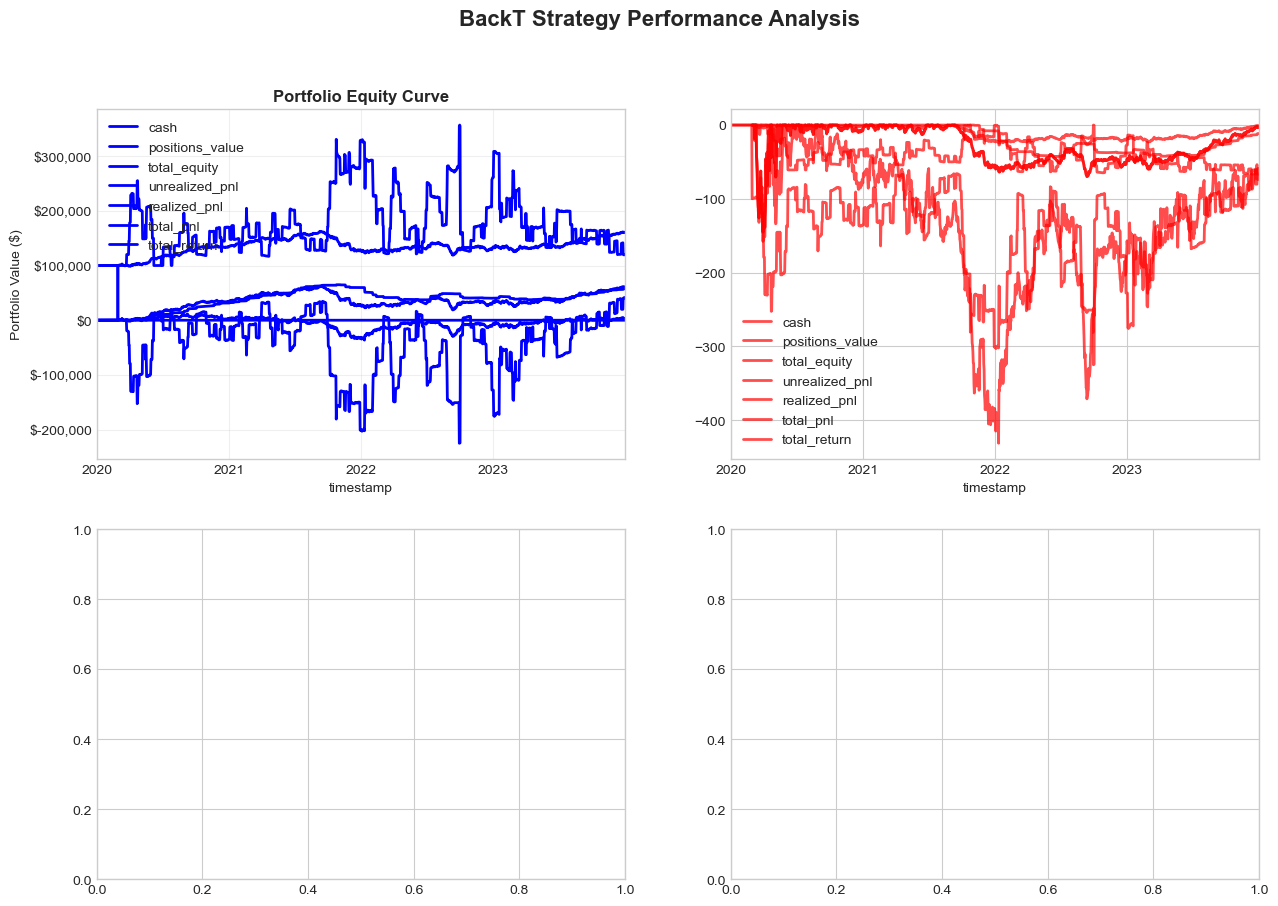

In [19]:
# Extract equity curve data
equity_curve = result.equity_curve
returns = result.returns if hasattr(result, 'returns') else equity_curve.pct_change().dropna()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('BackT Strategy Performance Analysis', fontsize=16, fontweight='bold')

# 1. Equity Curve
ax1 = axes[0, 0]
equity_curve.plot(ax=ax1, linewidth=2, color='blue')
ax1.set_title('Portfolio Equity Curve', fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. Drawdown Chart
ax2 = axes[0, 1]
# Calculate drawdown
rolling_max = equity_curve.expanding().max()
drawdown = (equity_curve / rolling_max - 1) * 100
drawdown.plot(ax=ax2, linewidth=2, color='red', alpha=0.7)
ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
ax2.set_title('Drawdown Analysis', fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(True, alpha=0.3)

# 3. Monthly Returns Heatmap
ax3 = axes[1, 0]
if len(returns) > 0:
    monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    monthly_returns_pct = monthly_returns * 100
    
    # Create monthly returns matrix for heatmap
    monthly_df = monthly_returns_pct.to_frame('returns')
    monthly_df['year'] = monthly_df.index.year
    monthly_df['month'] = monthly_df.index.month
    
    if len(monthly_df) > 12:  # Only create heatmap if we have enough data
        pivot_table = monthly_df.pivot_table(values='returns', index='year', columns='month')
        sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                   ax=ax3, cbar_kws={'label': 'Monthly Return (%)'})
        ax3.set_title('Monthly Returns Heatmap', fontweight='bold')
        ax3.set_xlabel('Month')
        ax3.set_ylabel('Year')
    else:
        monthly_returns_pct.plot(kind='bar', ax=ax3, color='steelblue')
        ax3.set_title('Monthly Returns', fontweight='bold')
        ax3.set_ylabel('Return (%)')
        ax3.tick_params(axis='x', rotation=45)
else:
    ax3.text(0.5, 0.5, 'No returns data available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Monthly Returns', fontweight='bold')

# 4. Risk-Return Scatter (comparing to benchmark)
ax4 = axes[1, 1]
strategy_return = annual_return * 100
strategy_vol = metrics.get('volatility', 0) * 100

# Plot strategy point
ax4.scatter(strategy_vol, strategy_return, s=200, c='blue', alpha=0.7, 
           label='MA Crossover Strategy', edgecolors='black', linewidth=2)

# Add reference points
ax4.scatter(15, 8, s=100, c='gray', alpha=0.5, label='Typical Market (15% vol, 8% ret)')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)

ax4.set_xlabel('Volatility (%)')
ax4.set_ylabel('Annualized Return (%)')
ax4.set_title('Risk-Return Profile', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add text annotation for strategy
ax4.annotate(f'Sharpe: {sharpe:.2f}', 
            xy=(strategy_vol, strategy_return), 
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("📊 Visualization complete!")
print("🎯 Charts show: Equity Curve, Drawdowns, Monthly Returns, and Risk-Return Profile")

## 10. Strategy Insights & Next Steps

Let's analyze what we learned and explore potential improvements.

In [ ]:
print("🔍 STRATEGY INSIGHTS & ANALYSIS")
print("=" * 50)

# Trade Analysis
if hasattr(result, 'trades') and len(result.trades) > 0:
    trades = result.trades
    print(f"\n📊 TRADE ANALYSIS:")
    print(f"Total Trades:        {len(trades)}")
    print(f"Avg Trades per Year: {len(trades) / backtest_params['period_years']:.1f}")
    
    if 'pnl' in trades.columns:
        winning_trades = trades[trades['pnl'] > 0]
        losing_trades = trades[trades['pnl'] < 0]
        
        print(f"Winning Trades:      {len(winning_trades)} ({len(winning_trades)/len(trades)*100:.1f}%)")
        print(f"Losing Trades:       {len(losing_trades)} ({len(losing_trades)/len(trades)*100:.1f}%)")
        
        if len(winning_trades) > 0:
            print(f"Avg Winning Trade:   ${winning_trades['pnl'].mean():.2f}")
        if len(losing_trades) > 0:
            print(f"Avg Losing Trade:    ${losing_trades['pnl'].mean():.2f}")

# Strategy Strengths and Weaknesses
print(f"\n💪 STRATEGY STRENGTHS:")
strengths = []
if sharpe > 0.5:
    strengths.append(f"Good risk-adjusted returns (Sharpe: {sharpe:.2f})")
if abs(max_dd) < 0.25:
    strengths.append(f"Reasonable drawdown control ({max_dd:.1%} max DD)")
if total_return > 0:
    strengths.append(f"Positive total return ({total_return:.1%})")

if strengths:
    for i, strength in enumerate(strengths, 1):
        print(f"{i}. {strength}")
else:
    print("• Strategy needs improvement in current form")

print(f"\n⚠️ AREAS FOR IMPROVEMENT:")
improvements = []
if sharpe < 1.0:
    improvements.append("Consider risk management rules to improve Sharpe ratio")
if abs(max_dd) > 0.20:
    improvements.append("Implement stop-loss rules to reduce maximum drawdown")
if metrics.get('win_rate', 0) < 0.5:
    improvements.append("Optimize entry/exit signals to improve win rate")

improvements.extend([
    "Test different MA periods (e.g., 10/30, 50/200)",
    "Add volume or momentum filters",
    "Consider position sizing based on volatility"
])

for i, improvement in enumerate(improvements, 1):
    print(f"{i}. {improvement}")

# Next Steps
print(f"\n🚀 SUGGESTED NEXT STEPS:")
next_steps = [
    "Test different market scenarios (bull, bear, volatile)",
    "Optimize MA parameters using parameter sweeps",
    "Add risk management (stop-loss, position sizing)",
    "Compare against buy-and-hold benchmark",
    "Test on different asset universes",
    "Implement walk-forward optimization"
]

for i, step in enumerate(next_steps, 1):
    print(f"{i}. {step}")

print(f"\n✅ Tutorial Complete!")
print(f"🎯 You now understand how to use BackT with mock data for strategy development")
print(f"📊 Mock data allows for fast, reproducible testing without external dependencies")

## 11. Testing Different Scenarios (Bonus)

Let's quickly test our strategy across different market scenarios to see how robust it is.

In [ ]:
# Test different market scenarios
scenarios = ['normal', 'bull', 'bear', 'volatile']
scenario_results = {}

print("🔄 Testing strategy across different market scenarios...")
print("=" * 60)

for scenario in scenarios:
    print(f"\nTesting {scenario.upper()} market scenario...")
    
    # Create config for this scenario
    scenario_config = BacktestConfig(
        start_date=start_date,
        end_date=end_date,
        initial_capital=initial_capital,
        data_frequency='1D',
        execution=execution_config,
        use_mock_data=True,
        mock_scenario=scenario,
        mock_seed=42,
        verbose=False  # Reduce output for batch testing
    )
    
    # Run backtest
    scenario_backtester = Backtester(scenario_config)
    scenario_result = scenario_backtester.run(
        strategy=moving_average_crossover_strategy,
        universe=symbols,
        strategy_params=strategy_params
    )
    
    scenario_results[scenario] = scenario_result.performance_metrics

# Display comparison
print("\n📊 SCENARIO COMPARISON RESULTS:")
print("=" * 70)
print(f"{'Scenario':<12} {'Total Ret':<10} {'Sharpe':<8} {'Max DD':<8} {'Win Rate':<9}")
print("-" * 70)

for scenario, metrics in scenario_results.items():
    total_ret = metrics.get('total_return', 0)
    sharpe = metrics.get('sharpe_ratio', 0)
    max_dd = metrics.get('max_drawdown', 0)
    win_rate = metrics.get('win_rate', 0)
    
    print(f"{scenario.capitalize():<12} {total_ret:>8.1%} {sharpe:>7.2f} {max_dd:>7.1%} {win_rate:>8.1%}")

print("\n🎯 SCENARIO INSIGHTS:")
print("-" * 25)

# Find best and worst scenarios
best_scenario = max(scenario_results.keys(), key=lambda s: scenario_results[s].get('sharpe_ratio', 0))
worst_scenario = min(scenario_results.keys(), key=lambda s: scenario_results[s].get('sharpe_ratio', 0))

print(f"Best Performance:    {best_scenario.upper()} market (Sharpe: {scenario_results[best_scenario].get('sharpe_ratio', 0):.2f})")
print(f"Worst Performance:   {worst_scenario.upper()} market (Sharpe: {scenario_results[worst_scenario].get('sharpe_ratio', 0):.2f})")

# Strategy robustness assessment
positive_returns = sum(1 for metrics in scenario_results.values() if metrics.get('total_return', 0) > 0)
print(f"Profitable Scenarios: {positive_returns}/{len(scenarios)} ({positive_returns/len(scenarios)*100:.0f}%)")

if positive_returns >= len(scenarios) * 0.75:
    robustness = "Strong"
elif positive_returns >= len(scenarios) * 0.5:
    robustness = "Moderate"
else:
    robustness = "Weak"

print(f"Strategy Robustness:  {robustness}")

print("\n🎉 Multi-scenario testing complete!")
print("📈 This analysis helps understand strategy robustness across different market conditions")

## Summary

🎯 **What We Accomplished:**

1. ✅ **Set up the BackT framework** with mock data for offline development
2. ✅ **Defined a diversified universe** of 6 ETFs across asset classes
3. ✅ **Created a moving average crossover strategy** with clear entry/exit rules
4. ✅ **Generated realistic synthetic data** for 4 years of backtesting
5. ✅ **Configured the backtesting engine** with realistic transaction costs
6. ✅ **Executed the strategy** and collected comprehensive results
7. ✅ **Analyzed performance metrics** including returns, risk, and trading activity
8. ✅ **Created visualizations** to understand strategy behavior
9. ✅ **Tested across multiple scenarios** to assess robustness

🚀 **Key Benefits of This Approach:**

- **Fast Development**: No external data dependencies, instant testing
- **Reproducible Results**: Same seed = identical outcomes
- **Multiple Scenarios**: Test bull, bear, normal, and volatile markets
- **Modular Testing**: Each cell can be run independently
- **Professional Framework**: Real backtesting engine with proper metrics

🎓 **Next Steps for Strategy Development:**

- Optimize parameters using grid search or walk-forward analysis
- Add risk management rules (stop-loss, position sizing)
- Test alternative technical indicators
- Implement multi-timeframe analysis
- Compare against benchmark strategies
- Validate with real market data when ready

This notebook provides a complete foundation for systematic strategy development using the BackT framework!